# Gesture Recognition for Hand Cricket Game using ConvNet in TF

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle

%matplotlib inline

In [3]:
np.random.seed(1)

## Prepare the Dataset

In [4]:
# define the path to the image dataset folder and other constants

DATADIR = "D:\Workplace\WorkBench\GitHub\Hand-Cricket-Umpire-DL\dataset\data"
CATEGORIES = ["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"]
IMG_SIZE = 256
NO_OF_CATEGORIES = len(CATEGORIES)

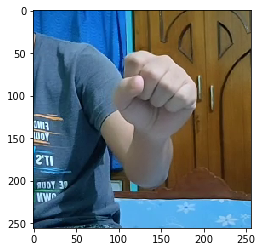

y = 0
shape = (256, 256, 3)


In [5]:
# let's read and see the examples of the pictures

index = 200          # example number m
category = 0       # class y

path = os.path.join(DATADIR, CATEGORIES[category])
img_name = os.listdir(path)[index]

img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_COLOR)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()
print("y = " + str(img_name[5:6]))
print("shape = " + str(img_array.shape))

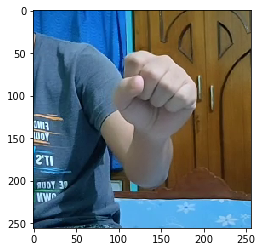

shape = (256, 256, 3)


In [6]:
# resize image acc to the input size to the Neural Network

img_array_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_array_resized)
plt.show()
print("shape = " + str(img_array_resized.shape))

In [7]:
def create_dataset(img_data_root_folder_path, sub_folder_category_name_list, img_size):
    '''
    Reads all the images from the dataset folders and returns a dataset (X, y)
    
    The dataset structure should be:
    A main root folder, inside which there are sub-folders, with their name same as the class name. 
    All these subfolders should contain all the images belonging to that class
    
    inputs:
    img_data_root_folder_path (string): enter the path to the root folder containing all the class folders
    sub_folder_category_name_list (list): list of strings containing the name of the sub-folders
    
    outputs:
    rawData_X: numpy array containing all the images in the form of numpy array
    rawData_y: list contining all the image category labels
    '''
    
    rawData = []
    rawData_X = []
    rawData_y = []
    
    for category in sub_folder_category_name_list:
        path = os.path.join(img_data_root_folder_path, category)  # forms path to all category folders
        class_num = sub_folder_category_name_list.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_array_resized = cv2.resize(img_array, (img_size, img_size))

                rawData.append([img_array_resized, class_num])
            except Exception as e:
                print("error reading " + str(img_name))
       
    # shuffle
    np.random.shuffle(rawData)
    
    # split into X and y
    for features, label in rawData:
        rawData_X.append(features)
        rawData_y.append(label)
        
    # convert to required output
    rawData_X = np.array(rawData_X).reshape(-1, img_size, img_size, 3)
    rawData_y = np.array(rawData_y).reshape(1, -1)
    
    return rawData_X, rawData_y

In [8]:
rawData_X, rawData_y = create_dataset(DATADIR, CATEGORIES, 256)

In [9]:
print ("number of examples = " + str(rawData_X.shape[0]))
print ("rawData_X shape: " + str(rawData_X.shape))
print ("rawData_y shape: " + str(rawData_y.shape))

number of examples = 2009
rawData_X shape: (2009, 256, 256, 3)
rawData_y shape: (1, 2009)


In [10]:
print(rawData_y)

[[3 5 3 ... 7 0 4]]


rawData_y = 5


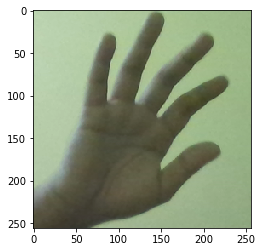

In [11]:
# Example of a picture
index = 1
plt.imshow(rawData_X[index])
print ("rawData_y = " + str(np.squeeze(rawData_y[:, index])))

In [12]:
# pickle out rawData_X and rawData_y

# pickle_out = open("rawData_X.pickle", "wb")
# pickle.dump(rawData_X, pickle_out)
# pickle_out.close()

# pickle_out = open("rawData_y.pickle", "wb")
# pickle.dump(rawData_y, pickle_out)
# pickle_out.close()

In [13]:
# pickle in rawData_X and rawData_y

# pickle_in = open("rawData_X.pickle", "rb")
# rawData_X = pickle.load(pickle_in)

# pickle_in = open("rawData_y.pickle", "rb")
# rawData_y = pickle.load(pickle_in)

In [14]:
# normalize the image data rawData_X
rawData_X = rawData_X/255.0

# convert the output label into one-hot vectors
rawData_y = np.eye(NO_OF_CATEGORIES)[rawData_y.reshape(-1)]

print ("number of training examples = " + str(rawData_X.shape[0]))
print ("rawData_X shape: " + str(rawData_X.shape))
print ("rawData_y shape: " + str(rawData_y.shape))

number of training examples = 2009
rawData_X shape: (2009, 256, 256, 3)
rawData_y shape: (2009, 8)


## 1. Simple ConvNet Model

#### model architecture:
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [15]:
import math
import scipy
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rawData_X, rawData_y, test_size=0.10, random_state=1)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1808
number of test examples = 201
X_train shape: (1808, 256, 256, 3)
y_train shape: (1808, 8)
X_test shape: (201, 256, 256, 3)
y_test shape: (201, 8)


In [18]:
# create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=(None, n_H0, n_W0, n_C0), name='X')
    Y = tf.placeholder(dtype=tf.float32, shape=(None, n_y), name='Y')
    
    return X, Y

In [19]:
X, Y = create_placeholders(IMG_SIZE, IMG_SIZE, 3, NO_OF_CATEGORIES)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 256, 256, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 8), dtype=float32)


In [20]:
# initialize_parameters

def initialize_parameters(w1, w2):
    """
    Initializes weight parameters to build a neural network with tensorflow. 
    The shapes are: w1, w2
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
        
    W1 = tf.get_variable("W1", w1, initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", w2, initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [21]:
w1 = [4, 4, 3, 8]
w2 = [2, 2, 8, 16]

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters(w1, w2)
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = \n" + str(parameters["W1"].eval()))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2 = \n" + str(parameters["W2"].eval()))
    print("W2.shape: " + str(parameters["W2"].shape))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1 = 
[[[[ 0.11547081 -0.15562162  0.14463945 -0.12213563 -0.161331
     0.0167321   0.00137798  0.15687598]
   [ 0.06261188  0.15809353 -0.13944083  0.1304368   0.14947264
     0.07770665 -0.0344099   0.02789916]
   [ 0.1310067   0.03547595  0.1019934   0.17467071 -0.16157703
    -0.06069881 -0.10278072 -0.06633689]]

  [[-0.1701455  -0.15981087 -0.06383926 -0.00349012 -0.14234345
    -0.05761932  0.00821769 -0.07173218]
   [ 0.14097519  0.11141728  0.18437327  0.0588678  -0.13764857
    -0.11404216  0.05882488  0.09655331]
   [ 0.09364428 -0.03100704  0.16560768  0.14417745  0.15409656
    -0.08602516 -0.12028332 -0.16772161]]

In [22]:
# CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [23]:
# forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 8 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F, 8, activation_fn=None)

    return Z3

In [24]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(IMG_SIZE, IMG_SIZE, 3, NO_OF_CATEGORIES)
    parameters = initialize_parameters(w1, w2)
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # test with 2 random placeholder values
    a = sess.run(Z3, {X: np.random.randn(2, IMG_SIZE, IMG_SIZE, 3), Y: np.random.randn(2, NO_OF_CATEGORIES)})
    print("Z3 = \n" + str(a))

Instructions for updating:
Use keras.layers.flatten instead.
Z3 = 
[[ 0.5571143   0.6620736  -1.4610059  -1.4009056  -1.5905805   1.7920098
  -1.6920853   1.5233216 ]
 [ 0.71367395  0.39384586 -1.3562427  -1.3406378  -1.6796511   1.8247614
  -1.5240567   1.2801194 ]]


In [25]:
# compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 8)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [26]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(IMG_SIZE, IMG_SIZE, 3, NO_OF_CATEGORIES)
    parameters = initialize_parameters(w1, w2)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # test with 4 random placeholder values
    a = sess.run(cost, {X: np.random.randn(4, IMG_SIZE, IMG_SIZE, 3), Y: np.random.randn(4, NO_OF_CATEGORIES)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 2.6432605


In [27]:
# mini batch creator

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [28]:
# model builder

def model(X_train, Y_train, X_test, Y_test, filter_dims, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, IMG_SIZE, IMG_SIZE, 3)
    Y_train -- test set, of shape (None, n_y = NO_OF_CATEGORIES)
    X_test -- training set, of shape (None, IMG_SIZE, IMG_SIZE, 3)
    Y_test -- test set, of shape (None, n_y = NO_OF_CATEGORIES)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    w1, w2 = filter_dims
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters(w1, w2)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss=cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], {X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [ ]:
w1 = [4, 4, 3, 8]
w2 = [2, 2, 8, 16]

train_accuracy, test_accuracy, parameters = model(X_train, y_train, X_test, y_test, [w1, w2])

Cost after epoch 0: 2.113417
Cost after epoch 5: 1.279243
Cost after epoch 10: 0.810770
Cost after epoch 15: 0.580420
